# Lab session 3: Multiple Outputs, Low Rank GPs and likelihood approximation

Gaussian Process Road Show, 13th February 2014
written by Ricardo Andrade Pacheco, Neil Lawrence and James Hensman

In this lab we are going to build on yestereday's work by looking at multiple output Gaussian processes, considering low rank approximations to Gaussian processes and considering approaches to dealing with non-Gaussian likelihoods. You should try and get at least as far as **Exercise 5**.

## 1 Getting started: Modelling Multiple Outputs

Just as in the first lab, we firstly specify to include plots in the notebook and to import relevant libraries.

In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


### Running Example

The first think we will look at is a multiple output model. Our aim is to jointly model all *sprinting* events from olympics since 1896. Data is provided by Rogers & Girolami's "First Course in Machine Learning". Firstly, let's load in the data.

In [2]:
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_sprints()
X = data['X']
y = data['Y']
print data['info'], data['details']

Olympics sprint event winning for men and women to 2008. Data is from Rogers and Girolami's First Course in Machine Learning. Data from the textbook 'A First Course in Machine Learning'. Available from http://www.dcs.gla.ac.uk/~srogers/firstcourseml/.


When using data sets it's good practice to cite the originators of the data, you can get information about the source of the data from `data['citation']`

In [3]:
print data['citation']

A First Course in Machine Learning. Simon Rogers and Mark Girolami: Chapman & Hall/CRC, ISBN-13: 978-1439824146


The data consists of all the male and female sprinting data for 100m, 200m and 400m since 1896 (six outputs in total). The ouput information can be found from: `data['output_info']`

In [4]:
print data['output_info']

{0: '100m Men', 1: '100m Women', 2: '200m Men', 3: '200m Women', 4: '400m Men', 5: '400m Women'}


In GPy we deal with multiple output data in a particular way. We specify the output we are interested in for modelling as an additional *input*. So whilst for this data, normally, the only input would be the year of the event. We additionally have an input giving the index of the output we are modelling. This can be seen from examining `data['X']`.

In [5]:
print 'First column of X contains the olympic years.'
print data['X'][:, 0]
print 'Second column of X contains the event index.'
print data['X'][:, 1]

First column of X contains the olympic years.
[ 1896.  1900.  1904.  1906.  1908.  1912.  1920.  1924.  1928.  1932.
  1936.  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.
  1984.  1988.  1992.  1996.  2000.  2004.  2008.  1928.  1932.  1936.
  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.  1984.
  1988.  1992.  1996.  2000.  2004.  2008.  1900.  1904.  1908.  1912.
  1920.  1924.  1928.  1932.  1936.  1948.  1952.  1956.  1960.  1964.
  1968.  1972.  1976.  1980.  1984.  1988.  1992.  1996.  2000.  2004.
  2008.  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.
  1984.  1988.  1992.  1996.  2000.  2004.  2008.  1896.  1900.  1904.
  1906.  1908.  1912.  1920.  1924.  1928.  1932.  1936.  1948.  1952.
  1956.  1960.  1964.  1968.  1972.  1976.  1980.  1984.  1988.  1992.
  1996.  2000.  2004.  2008.  1964.  1968.  1972.  1976.  1980.  1984.
  1988.  1992.  1996.  2000.  2004.  2008.]
Second column of X contains the event index.
[ 0.  0.  0. 

Now let's plot the data

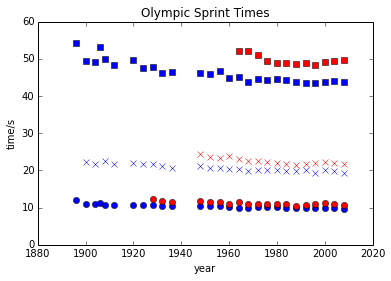

In [6]:
markers = ['bo', 'ro', 'bx', 'rx', 'bs', 'rs']
for i in range(6):
    # extract the event 
    x_event = X[np.nonzero(X[:, 1]==i), 0]
    y_event = y[np.nonzero(X[:, 1]==i), 0]
    pb.plot(x_event, y_event, markers[i])
pb.title('Olympic Sprint Times')
xlabel('year')
ylabel('time/s')

In the plot above red is women's events, blue is men's. Squares are 400 m, crosses 200m and circles 100m. Not all events were run in all years, for example the women's 400 m only started in 1964.

We will look at modelling the data using coregionalization approaches described in this morning's lecture. We introduced these approaches through the Kronecker product. To indicate we want to construct a covariance function of this type in GPy we've overloaded the `**` operator. Stricly speaking this operator means to the power of (like `^` in MATLAB). But for covariance functions we've used it to indicate a tensor product. The linear models of coregionalization we introduced in the lecture were all based on combining a matrix with a standard covariance function. We can think of the matrix as a particular type of covariance function, whose elements are referenced using the event indices. I.e. $k(0, 0)$ references the first row and column of the coregionalization matrix. $k(1, 0)$ references the second row and first column of the coregionalization matrix. Under this set up, we want to build a covariance where the first column from the features (the years) is passed to a covariance function, and the second column from the features (the event number) is passed to the coregionalisation matrix. Let's start by trying a intrinsic coregionalisation model (sometimes known as multitask Gaussian processes). Let's start by checking the help for the `coregionalize` covariance.

In [7]:
GPy.kern.Coregionalize?

The coregionalize matrix, $\mathbf{B}$, is itself is constructed from two other matrices, $\mathbf{B} = \mathbf{W}\mathbf{W}^\top + \text{diag}(\boldsymbol{\kappa})$. This allows us to specify a low rank form for the coregionalization matrix. However, for our first example we want to specify that the matrix $\mathbf{B}$ is not constrained to have a low rank form. 

In [8]:
kern = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(input_dim = 1,output_dim=6, rank=5)
#print X,y
print X.shape, y.shape

(126, 2) (126, 1)


Note here that the rank we specify is that of the $\mathbf{W}\mathbf{W}^\top$ part. When this part is combined with the diagonal matrix from $\mathbf{\kappa}$ the matrix $\mathbf{B}$ is totally general. This covariance function can now be used in a standard Gaussian process regression model. Let's build the model and optimize it.

In [9]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()
print model


Name                 : GP regression
Log-likelihood       : -125.318995948
Number of Parameters : 39
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  mul.rbf.variance         |   15.2863489844  |     +ve      |         |         
  mul.rbf.lengthscale      |   128.205049413  |     +ve      |         |         
  mul.coregion.W           |          (6, 5)  |              |         |         
  mul.coregion.kappa       |            (6,)  |     +ve      |         |         
  Gaussian_noise.variance  |  0.288990221731  |     +ve      |         |         


We can plot the results using the ability to 'fix inputs' in the `model.plot()` function. We can specify that column 1 should be fixed to event number 2 by passing `fixed_inputs = [(1, 2)]` to the model. To plot the results for all events on the same figure we also specify `fignum=1` in the loop as below. 

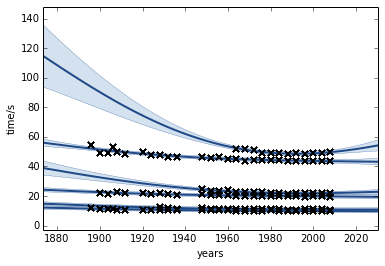

In [10]:
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)])
xlabel('years')
ylabel('time/s')

In [29]:
kern1 = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(input_dim=1, output_dim=6, rank=1)
kern2 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(input_dim=1, output_dim=6, rank=1)
kern = kern1 + kern2

There is a lot we can do with this model. First of all, each of the races is a different length, so the series have a different mean. We can include another coregionalization term to deal with the mean. Below we do this and reduce the rank of the coregionalization matrix to 1.

In [30]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

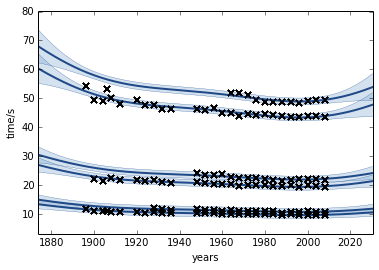

In [31]:
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)])
xlabel('years')
ylabel('time/s')

This is a simple form of the linear model of coregionalization. Note how confident the model is about what the women's 400 m performance would have been. You might feel that the model is being over confident in this region. Perhaps we are forcing too much sharing of information between the sprints. We could return to the intrinsic coregionalization model and force the two base covariance functions to share the same coregionalization matrix.

In [34]:
kern1 = GPy.kern.RBF(1, lengthscale=80) + GPy.kern.Bias(1)
kern2 = GPy.kern.Coregionalize(input_dim=1, output_dim=6, rank=5)
kern = kern1**kern2

In [35]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

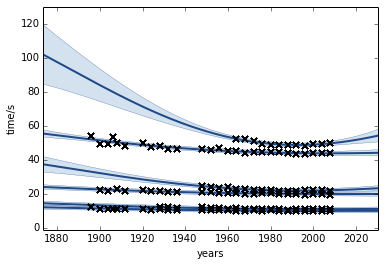

In [36]:
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)])
xlabel('years')
ylabel('time/s')

### Exercise 1

Can you fix the issue with over confidence in this model? Some things you might try include (a) adding additional covariance functions to handle shorter lengthscale effects. (b) Changing the rank of the coregionalization matrix. (c) Adding a coregionalized noise model using `GPy.kern.white()`.

In [37]:
# Question 1 answer here

Predictions in the multioutput case can be very effected by our covariance function *design*. This reflects the themes we saw on the first day where the importance of covariance function choice was emphasized at design time. 

Can you build a covariance matrix that coregionalizes separately over the sex of the athletes and the event identity? Does this matrix perform better?

In [46]:
X2 = np.zeros((X.shape[0], 3))
X2[:, 0] = X[:, 0]
X2[:, 1] = np.remainder(X[:, 1],2) == 1
X2[:, 2] = np.floor(X[:, 1]/2)
print X2[:, 2]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]


In [71]:
kern = ((GPy.kern.RBF(1, lengthscale=80)
         **GPy.kern.Coregionalize(input_dim=1, output_dim=3, rank=2)
         **GPy.kern.Coregionalize(input_dim=1, output_dim=3,rank=2))
        + GPy.kern.Bias(1)**GPy.kern.Coregionalize(input_dim=1, output_dim=3,rank=0)**GPy.kern.Coregionalize(input_dim=1, output_dim=3,rank=0))
kern2 = (GPy.kern.Bias(1)
           **GPy.kern.Coregionalize(input_dim=1, output_dim=2, rank=0)
           **GPy.kern.Coregionalize(input_dim=1, output_dim=3,rank=0))
kern = kern + kern2
model = GPy.models.GPRegression(X2, y, kern) 

#model.optimize()

LinAlgError: not positive definite, even with jitter.

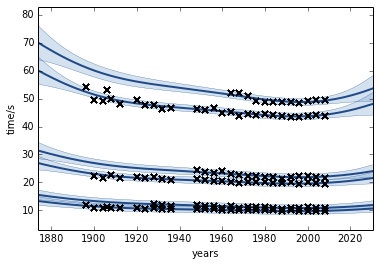

In [56]:
for sex in range(2):
    for event in range(3):
        model.plot(fignum=1,fixed_inputs=[(1, sex), (2, event)])
xlabel('years')
ylabel('time/s')

In [45]:
print model


Log-likelihood: -1.227e+02

                                 Name                                 |   Value    |  Constraints  |  Ties  |  prior  
----------------------------------------------------------------------------------------------------------------------
               [rbf**[coregion**coregion]]_rbf_variance               |   0.0569   |     (+ve)     |        |         
             [rbf**[coregion**coregion]]_rbf_lengthscale              |  64.1311   |     (+ve)     |        |         
    [rbf**[coregion**coregion]]_[coregion**coregion]_coregion_W0_0    |   3.8627   |               |        |         
    [rbf**[coregion**coregion]]_[coregion**coregion]_coregion_W1_0    |  10.1701   |               |        |         
  [rbf**[coregion**coregion]]_[coregion**coregion]_coregion_kappa_0   |   0.0000   |     (+ve)     |        |         
  [rbf**[coregion**coregion]]_[coregion**coregion]_coregion_kappa_1   |   0.0003   |     (+ve)     |        |         
    [rbf**[coregion

## 2 Low Rank Approximations

In the worst case, inference in a Gaussian process is $\mathcal{O}(n^3)$ computational complexity and $\mathcal{O}(n^2)$ storage. For efficient inference in larger data sets we need to consider approximations. One approach is low rank approximation of the covariance matrix (also known as sparse approximations or perhaps more accurately parsimonious approximations). We'll study these approximations by first creating a simple data set by sampling from a GP.

In [58]:
X = np.sort(np.random.rand(50,1)*12,0)
k = GPy.kern.rbf(1)
K = k.K(X)
K+= np.eye(50)*0.01 # add some independence (noise) to K
y = np.random.multivariate_normal(np.zeros(50), K).reshape(50,1)

Build a straightforward GP model of our simulation. We’ll also plot the posterior of $f$.

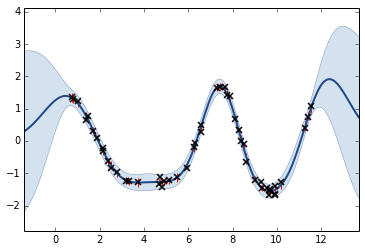

In [59]:
m = GPy.models.GPRegression(X,y)
m.optimize()
m.plot()
mu, var = m._raw_predict(X) # this fetches the posterior of f
pb.vlines(X[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r')

### Exercise 2

One thought that occurs is as follows. Do we need all the data to create this posterior estimate? Are any of the data points redundant? What happens to the model if you remove some data?

*Hint:* 
`X2 = np.delete(X,range(8),0)`
`y2 = np.delete(y,range(8),0)`

In [ ]:
# Exercise 2 answer here

### Building the Low Rank Approximation

Now we’ll consider a GP that uses a low rank approximation to fit the data.

In [62]:
Z = np.random.rand(3,1)*12
m = GPy.models.SparseGPRegression(X,y,Z=Z)
print m


Log-likelihood: -9.210e+01

       Name        |   Value   |  Constraints  |  Ties  |  prior  
------------------------------------------------------------------
      iip_0_0      |  5.7629   |               |        |         
      iip_1_0      |  7.8221   |               |        |         
      iip_2_0      |  11.6305  |               |        |         
   rbf_variance    |  1.0000   |     (+ve)     |        |         
  rbf_lengthscale  |  1.0000   |     (+ve)     |        |         
  noise_variance   |  1.0000   |     (+ve)     |        |         



In GPy, the sparse inputs $\mathbf{Z}$ are abbreviated 'iip' , for inducing input. Plot the posterior
of $u$ in the same manner as for the full GP:

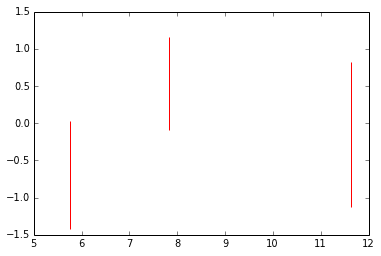

In [63]:
mu, var = m._raw_predict(Z) 
pb.vlines(Z[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r')

### Exercise 3

a) Optimise and plot the model. The inducing inputs are marked – how
are they placed? You can move them around with e.g. `m['iip_2_0'] = 100` . What
happens to the likelihood? What happens to the fit if you remove an input?

In [ ]:
# Exercise 3 a answer

b) How does the fit of the sparse compare with the full GP? Play around
with the number of inducing inputs, the fit should improve as $M$ increases. How many
inducing points are needed? What do you think happens in higher dimensions?

### Exercise 4

Can you build a low rank Gaussian process with the intrinsic model of coregionalization? Do you have to treat the 2nd input (which specifies the event number) in a special way?

## 3 Non Gaussian Likelihoods

Gaussian processes model functions. If our observation is a corrupted version of this function and the corruption process is *also* Gaussian, it is trivial to account for this. However, there are many circumstances where our observation may be non Gaussian. In these cases we need to turn to approximate inference techniques. As a simple illustration, we'll use a dataset of binary observations of the language that is spoken in different regions of East-Timor. First we will load the data and a couple of libraries to visualize it.

In [1]:
%pylab inline
import numpy as np
import GPy
import pylab as pb
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import cPickle as pickle
import urllib

urllib.urlretrieve('http://staffwww.dcs.sheffield.ac.uk/people/M.Zwiessele/gpss/lab2/EastTimor.pickle', 'EastTimor2.pickle')

#Load the data
with open("./EastTimor2.pickle","rb") as f:
    X,y,polygons = pickle.load(f)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/pymodules/python2.7/mpl_toolkits/__init__.py:2: UserWarning: Module GPy was already imported from /home/neil/SheffieldML/GPy/GPy/__init__.pyc, but /home/neil/.local/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)
/usr/lib/pymodules/python2.7/mpl_toolkits/__init__.py:2: UserWarning: Module dap was already imported from None, but /usr/lib/python2.7/dist-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


Now we will create a map of East Timor and, using GPy, plot the data on top of it. 
A classification model can be defined in a similar way to the regression model, but now using `GPy.models.GPClassification`. However, once we've define the model, we also need to update the approximation to the likelihood. This runs the Expectation propagation updates.


Log-likelihood: -4.370e+01

       Name        |  Value   |  Constraints  |  Ties  |  prior  
-----------------------------------------------------------------
   rbf_variance    |  1.0000  |     (+ve)     |        |         
  rbf_lengthscale  |  1.0000  |     (+ve)     |        |         



/home/neil/SheffieldML/GPy/GPy/likelihoods/noise_models/noise_distributions.py:422: UserWarning: Predictive quantiles are only computed when sampling.
  warnings.warn("Predictive quantiles are only computed when sampling.")


(<matplotlib.contour.QuadContourSet instance at 0x5bc8098>,
 <matplotlib.collections.PathCollection at 0x6c74d50>)

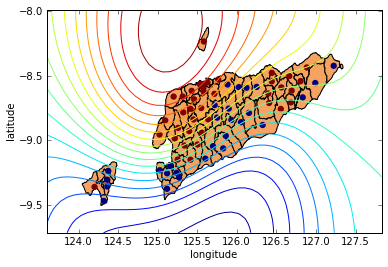


Log-likelihood: -4.370e+01

       Name        |  Value   |  Constraints  |  Ties  |  prior  
-----------------------------------------------------------------
   rbf_variance    |  1.0000  |     (+ve)     |        |         
  rbf_lengthscale  |  1.0000  |     (+ve)     |        |         



(<matplotlib.contour.QuadContourSet instance at 0x5bc82d8>,
 <matplotlib.collections.PathCollection at 0x6a20810>)

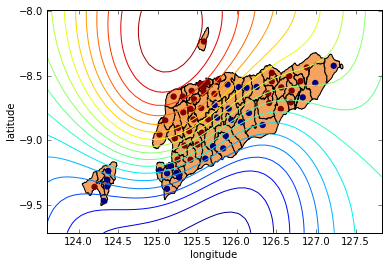

In [3]:
#Visualize a map of East-Timor
fig = pb.figure()
ax = fig.add_subplot(111)
for p in polygons:
    ax.add_collection(PatchCollection([Polygon(p)],facecolor="#F4A460"))
ax.set_xlim(124.,127.5)
ax.set_ylim(-9.6,-8.1)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

#Define the model
kern = GPy.kern.rbf(2)
m = GPy.models.GPClassification(X,y, kernel=kern)
m.update_likelihood_approximation() #Unlike regression we need to add this step.
print m
m.plot(ax=ax)

The decision boundary should be quite poor! However we haven't optimized the model. Try the following:




Log-likelihood: -2.780e+01

       Name        |  Value   |  Constraints  |  Ties  |  prior  
-----------------------------------------------------------------
   rbf_variance    |  4.1597  |     (+ve)     |        |         
  rbf_lengthscale  |  0.3264  |     (+ve)     |        |         



(<matplotlib.contour.QuadContourSet instance at 0x6252440>,
 <matplotlib.collections.PathCollection at 0x6717390>)

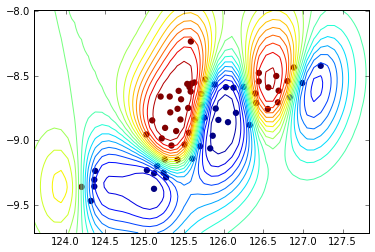

In [6]:
m.update_likelihood_approximation() #Unlike regression we need to add this step.
m.optimize()
print m
m.plot()

The optimization is based on the likelihood approximation that was made after we constructed the model. However, because we've now changed the model parameters the quality of that approximation has now probably deteriorated. To improve the model we should iterate between updating the Expectation propagation approximation and optimizing the model parameters. 

### Exercise 5

Write a for loop to optimize the model by iterating between EP and kernel parameters optimization. What happens with the decision boundary after these iterations?

In [ ]:
# Exercise 5 answer here

### Robust Regression: A Running Example

Yesterday we considered the olympic marathon data. In 1904 we noted there was an outlier example. Today we'll see if we can deal with that outlier by considering a non-Gaussian likelihood. Noise sampled from a Student-$t$ density is heavier tailed than that sampled from a Gaussian. However, it cannot be trivially assimilated into the Gaussian process. Below we use the *Laplace approximation* to incorporate this noise model.

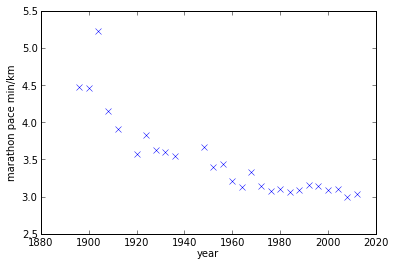

In [7]:
# redownload the marathon data from yesterday and plot
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']

pb.plot(X, Y, 'bx')
pb.xlabel('year')
pb.ylabel('marathon pace min/km')

In [8]:
GPy.likelihoods.noise_model_constructors.student_t?

In [ ]:
GPy.models.GPRegression?


Log-likelihood: -5.101e+00

       Name        |   Value   |  Constraints  |  Ties  |  prior  
------------------------------------------------------------------
   rbf_variance    |  0.1713   |     (+ve)     |        |         
  rbf_lengthscale  |  11.3743  |     (+ve)     |        |         
   bias_variance   |  3.8884   |     (+ve)     |        |         
   t_noise_std2    |  0.0091   |     (+ve)     |        |         



/home/neil/SheffieldML/GPy/GPy/likelihoods/laplace.py:400: UserWarning: Not perfect f_hat fit difference: 0.0416770535003
  warnings.warn("Not perfect f_hat fit difference: {}".format(difference))


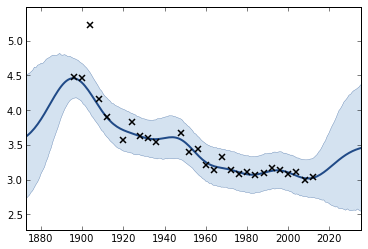

In [13]:
# make a student t likelihood with standard parameters
t_distribution = GPy.likelihoods.noise_model_constructors.student_t(deg_free=5, sigma2=2)
stu_t_likelihood = GPy.likelihoods.Laplace(Y.copy(), t_distribution)

kern = GPy.kern.rbf(1, lengthscale=10) + GPy.kern.bias(1)
model = GPy.models.GPRegression(X, Y, kernel=kern, likelihood=stu_t_likelihood)
model.constrain_positive('t_noise')

model.optimize()
model.plot()
#model.log_likelihood()
print model

### Exercise 6

Compare this model with a regression model using a Gaussian likelihood. What difference do you notice in the predictions? Which model do you think is better?

In [ ]:
# Exercise 6 answer

## 4 Sparse GP Classification

In this section we'll combine expectation propagation with the low rank approximation to build a simple image classificationa pplication. For this toy example we'll classify whether or not the subject of the image is wearing glasses.
correspond to whether the subject of the image is wearing glasses.
Set up the ipython environment and download the data:

In [14]:
import urllib
from scipy import io
import pylab as pb
import numpy as np
import pylab as pb
import GPy
urllib.urlretrieve('http://www.cs.nyu.edu/~roweis/data/olivettifaces.mat', 'faces.mat')
face_data = io.loadmat('faces.mat')

Here’s a simple way to visualise the data. Each pixel in the image will become an input
to the GP.

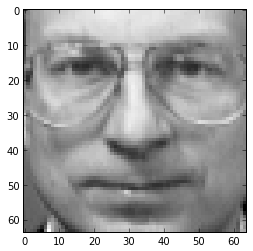

In [15]:
faces = face_data['faces'].T
pb.imshow(faces[120].reshape(64,64,order='F'),
interpolation='nearest',cmap=pb.cm.gray)

Now fetch the class labels

In [16]:
urllib.urlretrieve(\
'http://staffwww.dcs.sheffield.ac.uk/people/J.Hensman/gpsummer/datasets/has_glasses.np',
'has_glasses.np')
y = np.load('has_glasses.np')
y = np.where(y=='y',1,0).reshape(-1,1)

Divide the data into a training/testing set:

In [17]:
index = np.random.permutation(faces.shape[0])
num_training = 200
Xtrain = faces[index[:num_training],:]
Xtest = faces[index[num_training:],:]
ytrain = y[index[:num_training],:]
ytest = y[index[num_training:]]

Next we choose some inducing inputs. Here we've chosen inducing inputs by applying k-means clustering to the training data. Think about whether this is a good scheme for choosing the inputs? Can you
devise a better one?

In [18]:
from scipy import cluster
M = 8
Z, distortion = cluster.vq.kmeans(Xtrain,M)

Finally, we’re ready to build the classifier object.

In [19]:
k = GPy.kern.rbf(4096,lengthscale=50) + GPy.kern.white(4096,0.001)
m = GPy.models.SparseGPClassification(Xtrain, ytrain, kernel=k, Z=Z, normalize_X=True)
m.update_likelihood_approximation()
m.optimize()

/home/neil/SheffieldML/GPy/GPy/core/transformations.py:32: RuntimeWarning: overflow encountered in exp
  return np.where(x>lim_val, x, np.log(1. + np.exp(x)))


### Exercise 7

a) Look at the following figure. What is being shown? Why does it look
like this?

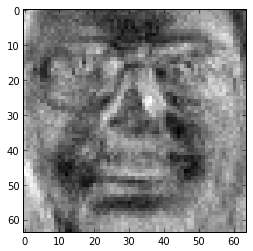

In [20]:
pb.figure()
pb.imshow(m.dL_dZ()[0].reshape(64,64,order='F'),interpolation='nearest',cmap=pb.cm.gray)

b) Write some code to evaluate the model’s performance, using the held-out data that we separated earlier. How is the error rate? Is that better than random
guessing? *Hint:* `GPy.util.classification.conf_matrix(prob_estimate,ytest)`

c) Write another simple for loop to optimize the model. How low can you get the error rate to go? What kind of kernel do you think might be appropriate for this classification task?